In [38]:
from aki_prj23_transparenzregister.utils.sql import connector, entities
from aki_prj23_transparenzregister.config.config_providers import JsonFileConfigProvider
import pandas as pd

In [39]:
session = connector.get_session(JsonFileConfigProvider("../../../../secrets.json"))
query_companies = session.query(entities.Company)  # .all()
query_relations = session.query(entities.CompanyRelation)  # .all()

companies_df: pd.DataFrame = pd.read_sql(str(query_companies), session.bind)  # type: ignore
companies_relations_df: pd.DataFrame = pd.read_sql(str(query_relations), session.bind)  # type: ignore

In [40]:
companies_df

company_id   company_hr  company_court_id  \
0              1   HRB 148048                 1   
1              2   HRA 301114                 2   
2              3   HRA 720015                 3   
3              4    HRB 97262                 1   
4              5    HRA 17617                 4   
...          ...          ...               ...   
3142        3143    HRB 13874                58   
3143        3144    HRB 71591                 4   
3144        3145     HRB 5297               102   
3145        3146  HRA 48546 B                12   
3146        3147   HRB 382018                 9   

                                           company_name company_company_type  \
0                           0 10 24 Telefondienste GmbH                 GMBH   
1        1. Staiger Grundstücksverwaltung GmbH & Co. KG                   KG   
2        1 A Autenrieth Kunststofftechnik GmbH & Co. KG                   KG   
3                                        01050.com GmbH                 GMBH   
4                  2. Schaper Objekt GmbH & Co. Kiel KG                   KG   
...                                                 ...                  ...   
3141                                WINGAS Holding GmbH                 GMBH   
3142                               WohnServicePlus GmbH                 GMBH   
3143  Wohnungsbaugesellschaft mit beschränkter Haftu...                 GMBH   
3144    Zalando Customer Care International SE & Co. KG                   KG   
3145                                       zebotec GmbH                 GMBH   

     company_founding_date                           company_business_purpose  \
0               2000-09-18  Gegenstand des Unternehmens ist die Entwicklun...   
1               2003-07-03                                               None   
2                     None                                               None   
3               2006-03-02  die Entwicklung und Bereitstellung von Dienstl...   
4                     None                                               None   
...                    ...                                                ...   
3141            2005-01-18  Die Beteiligung an Unternehmen, die den Einkau...   
3142            2013-11-27  Die Erbringung von Servicedienstleistungen run...   
3143            1989-07-04  Die Gesellschaft errichtet, bewirtschaftet, be...   
3144            2013-08-16                                               None   
3145            2002-04-03  ist Consulting und Dienstleistungen im Bereich...   

            company_street company_house_number company_zip_code company_city  \
0            Deelbögenkamp                    4            22297      Hamburg   
1     Johannes-Bieg-Straße                    8            74391    Erligheim   
2            Gewerbestraße                    8            72535  Heroldstatt   
3            Deelbögenkamp                    4            22297      Hamburg   
4             Metro-Straße                    2            40235   Düsseldorf   
...                    ...                  ...              ...          ...   
3141             Königstor                   20            34117       Kassel   
3142       Flughafenstraße                   99            40474   Düsseldorf   
3143          Taubenstraße                   47            47443        Moers   
3144          Mühlenstraße                   15            10243       Berlin   
3145  August-Borsig-Straße                   11            78467     Konstanz   

      company_longitude  company_latitude  company_pos_accuracy  \
0             10.017700         53.602620                   4.0   
1              9.097200         49.022500                   4.0   
2              9.664233         48.445633                   4.0   
3             10.017700         53.602620                   4.0   
4              6.821600         51.230100                   4.0   
...                 ...               ...                   ...   
3141           9.

In [41]:
def to_dict(data: object):
    return data.__dict__

In [42]:
def get_data():
    nodes = {}
    edges = []
    network_data = []
    edge_template = {
        "from": {
            "name": "Hans Wurst",
            "type": "Person",
        },
        "to": {"name": "Atos :D", "type": "Company"},
        "type": "Vorstand",
    }
    node_template = {
        "id": "(company|person)_\d",
        "label": "Name from entries",
        "type": "Company|Person",
        "shape": "dot",
        "color": "#729b79ff",
        # TODO add title for hover effect in graph "title": ""
    }
    data = session.query(entities.Relation).all()
    for entry in data[:1000]:
        company = (
            session.query(entities.Company)
            .filter(entities.Company.id == entry.company_id)
            .first()
        )
        if ("company_" + str(company.id)) not in nodes:
            nodes["company_" + str(company.id)] = {
                "label": company.name,
                "type": "Company",
                "shape": "dot",
                "color": "#729b79ff",
            }
        person_relations = (
            session.query(entities.PersonRelation)
            .filter(entities.PersonRelation.id == entry.id)
            .all()
        )
        for relation in person_relations:
            person = (
                session.query(entities.Person)
                .filter(entities.Person.id == relation.person_id)
                .first()
            )
            if ("person_" + str(person.id)) not in nodes:
                nodes["person_" + str(person.id)] = {
                    "label": f"{person.firstname}, {person.lastname}",
                    "type": "Person",
                    "shape": "dot",
                    "color": "blue",
                }
            edges.append(
                {
                    "from": "person_" + str(person.id),
                    "to": "company_" + str(company.id),
                    # "label": int(entry.relation)
                    "label": RelationTypeEnum.get_string_from_enum(entry.relation),
                }
            )
        company_relations = (
            session.query(entities.CompanyRelation)
            .filter(entities.CompanyRelation.id == entry.id)
            .all()
        )
        for relation in company_relations:
            company_2 = (
                session.query(entities.Company)
                .filter(entities.Company.id == relation.company2_id)
                .first()
            )
            if ("company_" + str(company_2.id)) not in nodes:
                nodes["company_" + str(company_2.id)] = {
                    "label": company_2.name,
                    "type": "Company",
                    "shape": "dot",
                    "color": "#729b79ff",
                }
            edges.append(
                {
                    "from": "company_" + str(company_2.id),
                    "to": "company_" + str(company.id),
                    "label": RelationTypeEnum.get_string_from_enum(entry.relation),
                }
            )
    return pd.DataFrame.from_dict(nodes, orient="index").reset_index(), pd.DataFrame(
        edges
    )


nodes, edges = get_data()
nodes.head()

index                                           label     type shape  \
0  company_1                     0 10 24 Telefondienste GmbH  Company   dot   
1   person_1                                  Nicolas, Tetau   Person   dot   
2   person_2                                   Lutz, Dammast   Person   dot   
3  company_2  1. Staiger Grundstücksverwaltung GmbH & Co. KG  Company   dot   
4   person_3                               Rosemarie, Tutsch   Person   dot   

       color  
0  #729b79ff  
1       blue  
2       blue  
3  #729b79ff  
4       blue

In [43]:
edges.head()

from         to                                   label
0  person_1  company_1  RelationshipRoleEnum.GESCHAEFTSFUEHRER
1  person_2  company_1          RelationshipRoleEnum.PROKURIST
2  person_3  company_2       RelationshipRoleEnum.KOMMANDITIST
3  person_4  company_2       RelationshipRoleEnum.KOMMANDITIST
4  person_5  company_2       RelationshipRoleEnum.KOMMANDITIST

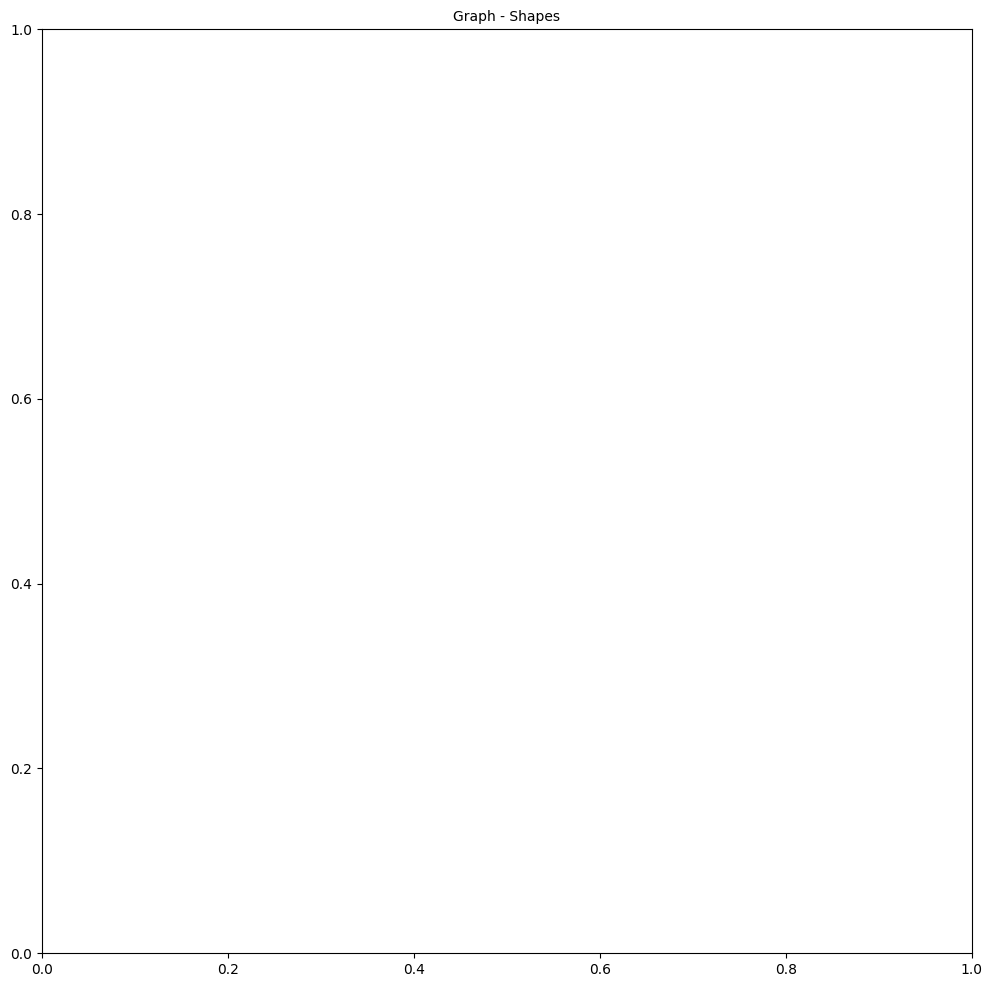

In [44]:
import networkx as nx
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111)
ax.set_title("Graph - Shapes", fontsize=10)

# initiate graph
graph = nx.MultiGraph()

# create edges from dataframe
graph = nx.from_pandas_edgelist(edges, source="from", target="to", edge_attr="label")

# update node attributes from dataframe
nodes_attr = nodes.set_index("index").to_dict(orient="index")
nx.set_node_attributes(graph, nodes_attr)

In [49]:
from pyvis.network import Network

net = Network(
    directed=False, neighborhood_highlight=True, bgcolor="white", font_color="black"
)

# pass networkx graph to pyvis
net.from_nx(graph)

net.inherit_edge_colors(False)
net.set_edge_smooth("dynamic")

net.repulsion()
net.show_buttons(filter_=["physics"])

# net.show_buttons()

# save graph as HTML
net.save_graph("./tmp.html")

In [48]:
net.generate_html("./tmp.html")

'<html>\n    <head>\n        <meta charset="utf-8">\n        \n            <script src="lib/bindings/utils.js"></script>\n            <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/vis-network/9.1.2/dist/dist/vis-network.min.css" integrity="sha512-WgxfT5LWjfszlPHXRmBWHkV2eceiWTOBvrKCNbdgDYTHrT2AeLCGbF4sZlZw3UMN3WtL0tGUoIAKsu8mllg/XA==" crossorigin="anonymous" referrerpolicy="no-referrer" />\n            <script src="https://cdnjs.cloudflare.com/ajax/libs/vis-network/9.1.2/dist/vis-network.min.js" integrity="sha512-LnvoEWDFrqGHlHmDD2101OrLcbsfkrzoSpvtSQtxK3RMnRV0eOkhhBN2dXHKRrUU8p2DGRTk35n4O8nWSVe1mQ==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>\n            \n        \n<center>\n<h1></h1>\n</center>\n\n<!-- <link rel="stylesheet" href="../node_modules/vis/dist/vis.min.css" type="text/css" />\n<script type="text/javascript" src="../node_modules/vis/dist/vis.js"> </script>-->\n        <link\n          href="https://cdn.jsdelivr.net/npm/bootstrap@5

In [53]:
import plotly.graph_objects as go

import networkx as nx

G = graph
pos = nx.fruchterman_reingold_layout(G)
pos

{'person_1': array([-0.94645625, -0.09531674]),
 'company_1': array([-0.94813806, -0.08389861]),
 'person_2': array([-0.97526002, -0.0871018 ]),
 'person_3': array([0.54134536, 0.64503521]),
 'company_2': array([0.51604873, 0.62229675]),
 'person_4': array([0.5037812 , 0.62973112]),
 'person_5': array([0.5285213 , 0.65385073]),
 'person_6': array([0.52969128, 0.61765826]),
 'person_7': array([0.49968848, 0.60013074]),
 'person_8': array([0.5363701 , 0.65151918]),
 'person_9': array([-0.77727145,  0.30530825]),
 'company_3': array([-0.81598961,  0.32018232]),
 'person_10': array([-0.8483026,  0.332434 ]),
 'company_4': array([-0.97412682, -0.09859657]),
 'company_2213': array([ 0.38867021, -0.93487197]),
 'company_5': array([ 0.39772275, -0.94155639]),
 'person_11': array([-0.29175109, -0.17030789]),
 'company_6': array([-0.29339093, -0.13240719]),
 'person_12': array([-0.29848012, -0.19507937]),
 'person_13': array([-0.32924238, -0.13631371]),
 'person_14': array([-0.35154879, -0.12680

In [57]:
nodes = pd.DataFrame(pos)
nodes

person_1  company_1  person_2  person_3  company_2  person_4  person_5  \
0 -0.946456  -0.948138 -0.975260  0.541345   0.516049  0.503781  0.528521   
1 -0.095317  -0.083899 -0.087102  0.645035   0.622297  0.629731  0.653851   

   person_6  person_7  person_8  ...  person_857  person_858  company_112  \
0  0.529691  0.499688  0.536370  ...   -0.370287    0.008841     0.010732   
1  0.617658  0.600131  0.651519  ...   -0.695017    0.670919     0.694699   

   person_859  company_113  person_860  person_861  company_114  person_862  \
0    0.781454     0.750398    0.710121   -0.950943    -0.966813   -0.958188   
1   -0.123724    -0.122161   -0.120467    0.060776     0.067629    0.078402   

   person_863  
0   -1.000000  
1    0.069188  

[2 rows x 980 columns]

In [ ]:
Xv = [pos[k][0] for k in range(N)]
Yv = [pos[k][1] for k in range(N)]
Xed = []
Yed = []
for edge in E:
    Xed += [pos[edge[0]][0], pos[edge[1]][0], None]
    Yed += [pos[edge[0]][1], pos[edge[1]][1], None]

trace3 = Scatter(
    x=Xed,
    y=Yed,
    mode="lines",
    line=dict(color="rgb(210,210,210)", width=1),
    hoverinfo="none",
)
trace4 = Scatter(
    x=Xv,
    y=Yv,
    mode="markers",
    name="net",
    marker=dict(
        symbol="circle-dot",
        size=5,
        color="#6959CD",
        line=dict(color="rgb(50,50,50)", width=0.5),
    ),
    text=labels,
    hoverinfo="text",
)

annot = (
    "This networkx.Graph has the Fruchterman-Reingold layout<br>Code:"
    + "<a href='http://nbviewer.ipython.org/gist/empet/07ea33b2e4e0b84193bd'> [2]</a>"
)

data1 = [trace3, trace4]
fig1 = Figure(data=data1, layout=layout)
fig1["layout"]["annotations"][0]["text"] = annot
py.iplot(fig1, filename="Coautorship-network-nx")

In [50]:
import plotly.graph_objects as go

import networkx as nx

G = graph
pos = nx.fruchterman_reingold_layout(G)
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]["pos"]
    x1, y1 = G.nodes[edge[1]]["pos"]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color="#888"),
    hoverinfo="none",
    mode="lines",
)

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]["pos"]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers",
    hoverinfo="text",
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale="YlGnBu",
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15, title="Node Connections", xanchor="left", titleside="right"
        ),
        line_width=2,
    ),
)

KeyError: 'pos'

In [ ]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append("# of connections: " + str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [ ]:
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title="<br>Network graph made with Python",
        titlefont_size=16,
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=5, r=5, t=40),
        annotations=[
            dict(
                text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                showarrow=False,
                xref="paper",
                yref="paper",
                x=0.005,
                y=-0.002,
            )
        ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    ),
)
fig.show()